In [1]:
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [38]:
mydb = mysql.connector.connect(host='localhost',
                               user='mimicuser',
                               passwd='mimic',
                               database='mimiciiiv13',
                              auth_plugin='mysql_native_password')

First approach to query mysql from python

In [39]:
cursor = mydb.cursor(buffered=True)
cursor.execute('SELECT * FROM LABEVENTS LIMIT 5')
result = cursor.fetchall()
print(result)

[(1, 2, 163353, 51143, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', None), (2, 2, 163353, 51144, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', None), (3, 2, 163353, 51146, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', None), (4, 2, 163353, 51200, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', None), (5, 2, 163353, 51221, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', 'abnormal')]


Preferred way is to load query result into a DataFrame

In [48]:
df = pd.read_sql_query("SELECT * FROM LABEVENTS LIMIT 5;", mydb)

In [49]:
df

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,1,2,163353,51143,2138-07-17 20:48:00,0,0.0,%,None
1,2,2,163353,51144,2138-07-17 20:48:00,0,0.0,%,None
2,3,2,163353,51146,2138-07-17 20:48:00,0,0.0,%,None
3,4,2,163353,51200,2138-07-17 20:48:00,0,0.0,%,None
4,5,2,163353,51221,2138-07-17 20:48:00,0,0.0,%,abnormal


Here is how we are going to test the mutual information idea:

- create a temporary table that combines LABEVENTS(SUBJECT_ID, ITEMID, CHARTTIME), Lab2Hpo(NEGATED, MAP_TO), D_LABEVENTS(LOINC)
- define patient phenotype: having a phenotype > 3 times 
  

In [50]:
start = datetime.datetime.now()
cursor.execute("DROP TEMPORARY TABLE IF EXISTS combined")
cursor.execute("CREATE TEMPORARY TABLE combined AS \
               SELECT LABEVENTS.ROW_ID, LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LABEVENTS.ITEMID, LABEVENTS.CHARTTIME, \
               LabHpo.NEGATED, LabHpo.MAP_TO \
               FROM LABEVENTS JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID")
end = datetime.datetime.now()
print('running time: {}s'.format((end - start).total_seconds()))

running time: 164.120642s


create a small dataset of 100 encounters (88 distinct patient) for testing with the following code:

"create table test as (with adm as (select distinct subject_id, hadm_id from admissions limit 100) select combined.* from adm left join combined on adm.subject_id = combined.subject_id and adm.hadm_id = combined.hadm_id);"

In [52]:
cursor.execute("CREATE INDEX combined_negated ON combined (NEGATED)")

There are some questions we need to further explore. 

* How many times did each patient get admitted into ICU?

From the following query, we can see that about 84% patients were admitted only once, 11% were admitted twice, and the rest 5% were admitted three times or more. We could just focus on the 84%. This will make our task easier as we do not need to worry about effects from other admissions.  

In [7]:
admissions_per_patient = pd.read_sql_query("WITH adm_per_patient AS \
    (SELECT count(*) as adm_time FROM ADMISSIONS GROUP BY SUBJECT_ID) \
    SELECT adm_time, count(*) as patient_n FROM adm_per_patient GROUP BY adm_time ORDER BY patient_n DESC", mydb)
admissions_per_patient['percent'] = admissions_per_patient.patient_n / np.sum(admissions_per_patient.patient_n)
admissions_per_patient[0:10]

,adm_time,patient_n,percent
0,1,38983,0.837984
1,2,5160,0.110920
2,3,1342,0.028848
3,4,508,0.010920
4,5,246,0.005288
5,6,113,0.002429
6,7,51,0.001096
7,8,31,0.000666
8,9,26,0.000559
9,10,14,0.000301


* How many abnormal phenotypes does each patient have at each admission?

From the histogram, we can see that most patients have ~20 abnormal phenotypes. 

In [8]:
abnormPerPatientAdm = pd.read_sql_query("WITH abnormal_per_patient_adm AS \
(SELECT SUBJECT_ID, HADM_ID, count(*) AS abnormal_n \
FROM combined WHERE NEGATED = 'F' GROUP BY SUBJECT_ID, HADM_ID) \
SELECT abnormal_n, count(*) AS n FROM abnormal_per_patient_adm GROUP BY abnormal_n ORDER BY n DESC ", mydb)

In [9]:
abnormPerPatientAdm.loc[abnormPerPatientAdm.n > 500, :]

,abnormal_n,n
0,8,1465
1,7,1446
2,9,1306
3,6,1260
4,10,1031
5,5,1026
6,1,915
7,4,823
8,11,783
9,12,734


A better way is to plot this.

In [51]:
abnormalities_per_patient_adm = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, count(*) AS abnormal_n \
FROM combined WHERE NEGATED = 'F' GROUP BY SUBJECT_ID, HADM_ID", mydb)

In [11]:
abnormalities_per_patient_adm.abnormal_n.describe()

count    73678.000000
mean       127.217731
std        207.226446
min          1.000000
25%         24.000000
50%         67.000000
75%        142.000000
max       9467.000000
Name: abnormal_n, dtype: float64

In [12]:
bins = pd.cut(abnormalities_per_patient_adm.abnormal_n, bins = [-1, 0, 25, 50, 75, 100, 125, 150, 175, 200, 3000, 10000])
hist_data = abnormalities_per_patient_adm.groupby(bins).size()

In [13]:
hist_data.values

array([    0, 19284, 10949,  9581,  7447,  5339,  3707,  2785,  2252,
       12316,    18])

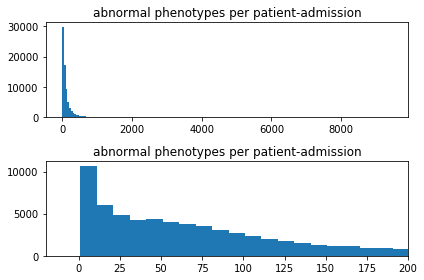

In [14]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(0, np.max(abnormalities_per_patient_adm.abnormal_n), 50))
plt.title('abnormal phenotypes per patient-admission')
ax = fig.add_subplot(212)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(-9, np.max(abnormalities_per_patient_adm.abnormal_n), 10))
plt.xlim((-20, 200))
plt.title('abnormal phenotypes per patient-admission')
plt.tight_layout()
plt.show()

* How to assign that a patient has a phenotype at one admission?

We look at how many times does each abnormal phenotype occur for each patient admission.

In [15]:
pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, MAP_TO \
    FROM combined \
    WHERE NEGATED = 'F' \
    limit 5", mydb)

,SUBJECT_ID,HADM_ID,MAP_TO
0,2,163353,HP:0031851
1,2,163353,HP:0020062
2,2,163353,HP:0025547
3,2,163353,HP:0025547
4,2,163353,HP:0025066


In [16]:
abnormal_occurrence = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, MAP_TO, count(*) as n \
    FROM combined \
    WHERE NEGATED = 'F' \
    GROUP BY SUBJECT_ID, HADM_ID, MAP_TO", mydb)
abnormal_occurrence.head()

,SUBJECT_ID,HADM_ID,MAP_TO,n
0,2,163353.0,HP:0031851,1
1,2,163353.0,HP:0020062,1
2,2,163353.0,HP:0025547,2
3,2,163353.0,HP:0025066,1
4,2,163353.0,HP:0001873,1


There is an extreme case where a patient had mapped to 906 Hypercapnia HP:0012416

In [17]:
abnormal_occurrence[abnormal_occurrence.n == 906]

,SUBJECT_ID,HADM_ID,MAP_TO,n
446584,12613,168201.0,HP:0012416,906


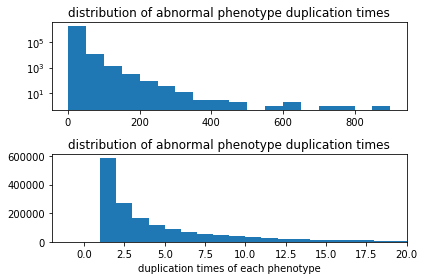

In [18]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(abnormal_occurrence.n, 
        bins = np.arange(0, np.max(abnormal_occurrence.n), 50))
plt.yscale('log')
plt.title('distribution of abnormal phenotype duplication times')
ax = fig.add_subplot(212)
ax.hist(abnormal_occurrence.n, 
        bins = np.arange(0, np.max(abnormal_occurrence.n), 1))
plt.xlim((-2, 20))
plt.xlabel('duplication times of each phenotype')
plt.title('distribution of abnormal phenotype duplication times')
plt.tight_layout()
plt.show()

From the above plot, we conclude that the majority of HPO only occurred once for every patient at each visit. There are some extreme cases where one patient was assigned with hundreds of HPO terms in one admission. They might indicate patients that had lone stay.

In [19]:
stay_duration = pd.read_sql_query("SELECT \
    SUBJECT_ID, HADM_ID, DISCHTIME, ADMITTIME, CEILING(TIME_TO_SEC(TIMEDIFF(DISCHTIME, ADMITTIME))/(3600 * 24)) as days \
    FROM ADMISSIONS", mydb)

In [20]:
stay_duration.head()

,SUBJECT_ID,HADM_ID,DISCHTIME,ADMITTIME,days
0,2,163353,2138-07-21 15:48:00,2138-07-17 19:04:00,4
1,3,145834,2101-10-31 13:58:00,2101-10-20 19:08:00,11
2,4,185777,2191-03-23 18:41:00,2191-03-16 00:28:00,8
3,5,178980,2103-02-04 12:15:00,2103-02-02 04:31:00,3
4,6,107064,2175-06-15 16:00:00,2175-05-30 07:15:00,17


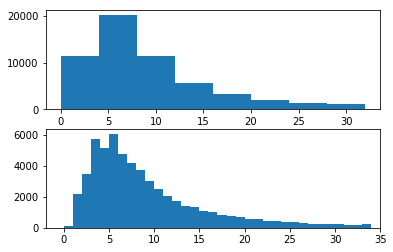

In [21]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(stay_duration.days, 
        bins = np.arange(0, np.max(stay_duration.days), 4))
ax = fig.add_subplot(212)
ax.hist(stay_duration.days, 
        bins = np.arange(0, np.max(stay_duration.days), 1))
plt.xlim((-2, 35))
plt.show()

Most patients stayed in ICU for around 5 days. 

* What is the common diagnosis at each admission?

In [22]:
diagnosis_count = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, \
    CASE \
    WHEN(ICD9_CODE LIKE 'V%') THEN SUBSTRING(ICD9_CODE, 1, 3) \
    WHEN(ICD9_CODE LIKE 'E%') THEN SUBSTRING(ICD9_CODE, 1, 4) \
    ELSE SUBSTRING(ICD9_CODE, 1, 3) END AS ICD9 \
    FROM DIAGNOSES_ICD", mydb)

In [23]:
diagnosis_count.drop_duplicates().groupby('ICD9').size().sort_values(ascending=False).head()

ICD9
401    21305
427    17226
276    15101
272    14558
414    14410
dtype: int64

In [24]:
diagnosis_count.head(n = 10)

,SUBJECT_ID,HADM_ID,ICD9
0,2,163353,V30
1,2,163353,V05
2,2,163353,V29
3,3,145834,038
4,3,145834,785
5,3,145834,584
6,3,145834,427
7,3,145834,410
8,3,145834,428
9,3,145834,682


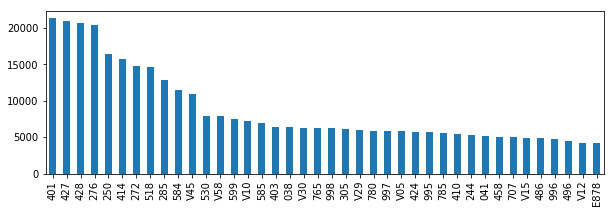

In [25]:
diagnosis_count.ICD9.value_counts().head(n = 40).plot(kind='bar')
fig = plt.gcf()
fig.set_size_inches(10, 3)
plt.show()

The top diagnosis codes are:

* 401 Essential hypertension
* 427 Cardiac dysrhythmias
* 428 Heart failure
* 276 Disorders of fluid, electrolyte, and acid-base balance
* 414 Other forms of chronic ischemic heart disease
* 272 Disorders of lipoid metabolism
* 518 Other diseases of lung
* 285 Other and unspecified anemias
* 584 Acute renal failure
* V45 Other postprocedural states

Now we can try to determine the mutual information content for one diagnosis: Heart failure. Our algorithm is like the following:
* Group patient+admissions into two groups: having code 428 and not having it;
* For each group, count total patient+admission, count patient+admission having Phenotype X or not. 
* For each group, count total patient+admission, count patient+admission having Phenotype Y or not.
* For each group, count total patient+admission, count patient+admission having Phenotype XY, X NOT Y, Y NOT X, NOT X NOT Y. 

We look at what are the commonly seen abnormalities for heart failure patients. We count each phenotype once if they happen multiple times during one admission for each patient. 

In [26]:
pheno_heart_failure = pd.read_sql_query("WITH p AS (SELECT DISTINCT SUBJECT_ID, HADM_ID FROM DIAGNOSES_ICD WHERE ICD9_CODE LIKE '428%'), \
    c AS (SELECT DISTINCT SUBJECT_ID, HADM_ID, MAP_TO FROM combined WHERE NEGATED = 'F') \
    SELECT DISTINCT c.MAP_TO, count(DISTINCT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO) AS count \
FROM c JOIN p ON c.SUBJECT_ID = p.SUBJECT_ID AND c.HADM_ID = p.HADM_ID GROUP BY c.MAP_TO ORDER BY count DESC", mydb)

In [27]:
pheno_heart_failure.head(n = 10)

,MAP_TO,count
0,HP:0003074,12079
1,HP:0001943,12040
2,HP:0031851,11871
3,HP:0003138,11798
4,HP:0020062,11055
5,HP:0002901,10839
6,HP:0020059,10686
7,HP:0012085,10670
8,HP:0020060,10559
9,HP:0020063,10448


The result shows that the most frequent top 6 abnormal phenotypes for patients diagnosed with heart failure: 

* HP:0003074 Hyperglycemia
* HP:0001943 Hypoglycemia
* HP:0031851 Reduced hematocrit
* HP:0003138 Increased blood urea nitrogen
* HP:0020062 Decreased hemoglobin concentration
* HP:0002901 Hypocalcemia

Calculate I(HP:0003074 | heart failure). 
To do this, we need a table for (subject, admission, hasPhenotype) for HP:0003074; then another table for (subject, admission, hasDiagnosis) for ICD9:428\*. Then we can join them together on (subject, admission). Finally, calculate frequencies of (phenotype | diagnosis).

In [28]:
pd.read_sql_query("SELECT DISTINCT SUBJECT_ID, HADM_ID, IF (ICD9_CODE LIKE '428%', 'Y', 'N') AS hasDiagnosis FROM DIAGNOSES_ICD LIMIT 10", mydb)
    

,SUBJECT_ID,HADM_ID,hasDiagnosis
0,2,163353,N
1,3,145834,N
2,3,145834,Y
3,4,185777,N
4,5,178980,N
5,6,107064,N
6,7,118037,N
7,8,159514,N
8,9,150750,N
9,9,150750,Y


In [29]:
pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, IF(SUM(MAP_TO = 'HP:0003074') > 0, 'Y', 'N') AS hasPhenotype \
    FROM combined \
    where NEGATED = 'F' AND HADM_ID IS NOT NULL \
    GROUP BY SUBJECT_ID, HADM_ID \
    LIMIT 10", mydb)

,SUBJECT_ID,HADM_ID,hasPhenotype
0,2,163353,N
1,3,145834,Y
2,4,185777,Y
3,5,178980,N
4,6,107064,Y
5,7,118037,N
6,8,159514,N
7,9,150750,Y
8,10,184167,N
9,11,194540,Y


In [52]:
pd.read_sql_query("SELECT * FROM combined LIMIT 10", mydb)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,NEGATED,MAP_TO
0,1,2,163353,51143,2138-07-17 20:48:00,U,ERROR3
1,2,2,163353,51144,2138-07-17 20:48:00,T,HP:0011991
2,3,2,163353,51146,2138-07-17 20:48:00,T,HP:0031806
3,4,2,163353,51200,2138-07-17 20:48:00,T,HP:0001879
4,5,2,163353,51221,2138-07-17 20:48:00,F,HP:0031851
5,6,2,163353,51222,2138-07-17 20:48:00,F,HP:0020062
6,7,2,163353,51244,2138-07-17 20:48:00,T,HP:0040088
7,8,2,163353,51248,2138-07-17 20:48:00,F,HP:0025547
8,9,2,163353,51249,2138-07-17 20:48:00,F,HP:0025547
9,10,2,163353,51250,2138-07-17 20:48:00,F,HP:0025066


In [161]:
p1 = pd.read_sql_query("WITH \
    l AS \
        (SELECT DISTINCT SUBJECT_ID, HADM_ID, IF (ICD9_CODE LIKE '428%', 'Y', 'N') AS hasDiagnosis \
        FROM DIAGNOSES_ICD), \
    r AS \
        (SELECT SUBJECT_ID, HADM_ID, \
        IF(SUM(MAP_TO = 'HP:0003074') > 0, 'Y', 'N') AS hasPhenotype1, \
        IF(SUM(MAP_TO = 'HP:0002850') > 0, 'Y', 'N') AS hasPhenotype2 \
        FROM combined \
        where NEGATED = 'F' AND HADM_ID IS NOT NULL \
        GROUP BY SUBJECT_ID, HADM_ID) \
    SELECT l.SUBJECT_ID, l.HADM_ID, l.hasDiagnosis, r.hasPhenotype1, r.hasPhenotype2 \
    FROM l LEFT JOIN r ON l.SUBJECT_ID = r.SUBJECT_ID AND l.HADM_ID = r.HADM_ID", mydb)

In [162]:
p1.head()

,SUBJECT_ID,HADM_ID,hasDiagnosis,hasPhenotype1,hasPhenotype2
0,2,163353,N,N,N
1,3,145834,N,Y,N
2,3,145834,Y,Y,N
3,4,185777,N,Y,N
4,5,178980,N,N,N


Now that we have the phenotype-diagnosis table, we can compute I(P|D).

Calculate p(P = 'Y'), p(D = 'Y'), 
p(P = 'Y' and D = 'Y'), p(P = 'N' and D = 'Y'), p(P = 'Y' and D = 'N'), p(P = 'N' and D = 'N')


In [108]:
def mutual_information(dataset, phenotype):
    """
    pPYDY = sum(np.logical_and(p == 'Y', d == 'Y')) / SIZE
    pPNDY = sum(np.logical_and(p == 'N', d == 'Y')) / SIZE
    pPYDN = sum(np.logical_and(p == 'Y', d == 'N')) / SIZE
    pPNDN = sum(np.logical_and(p == 'N', d == 'N')) / SIZE
    """
    p = dataset[phenotype]
    d = dataset['hasDiagnosis']
    SIZE = len(dataset)
    pPY = sum(p == 'Y') / SIZE
    pPN = 1 - pPY
    pDY = sum(d == 'Y') / SIZE
    pDN = 1 - pDY
    temp = dataset.groupby([phenotype, 'hasDiagnosis']).size()
    if len(temp) < 4:
        return (99.99)
    pPYDY = temp.loc['Y', 'Y'] / SIZE
    pPNDY = temp.loc['N', 'Y'] / SIZE
    pPYDN = temp.loc['Y', 'N'] / SIZE
    pPNDN = temp.loc['N', 'N'] / SIZE
    
    I = pPYDY * np.log2(pPYDY / (pPY * pDY)) + \
        pPNDY * np.log2(pPNDY / (pPN * pDY)) + \
        pPYDN * np.log2(pPYDN / (pPY * pDN)) + \
        pPNDN * np.log2(pPNDN / (pPN * pDN))
        
    return(I)

In [163]:
Ip1d = mutual_information(p1, phenotype = 'hasPhenotype1')
Ip2d = mutual_information(p1, phenotype = 'hasPhenotype2')

In [164]:
print(Ip1d)
print(Ip2d)

-0.0075683796680602825
-0.02569630460172535


In [173]:
def mutual_information2(dataset):
    p1 = dataset['hasPhenotype1']
    p2 = dataset['hasPhenotype2']
    d = dataset['hasDiagnosis']
    SIZE = len(dataset)
    p1Y = sum(p1 == 'Y') / SIZE
    p2Y = sum(p2 == 'Y') / SIZE
    pDY = sum(d == 'Y') / SIZE
    pDN = 1 - pDY
    
    """    
    pPYY = sum(np.logical_and(p1 == 'Y', p2 == 'Y')) / SIZE
    pPYN = sum(np.logical_and(p1 == 'Y', p2 == 'N')) / SIZE
    pPNY = sum(np.logical_and(p1 == 'N', p2 == 'Y')) / SIZE
    pPNN = sum(np.logical_and(p1 == 'N', p2 == 'N')) / SIZE
    """
    
    temp1 = dataset.groupby(['hasPhenotype1', 'hasPhenotype2']).size()
    if len(temp1) < 4:
        print(temp1)
        return (-99.99)
    pPYY = temp1.loc(axis=0)['Y', 'Y'] / SIZE
    pPYN = temp1.loc(axis=0)['Y', 'N'] / SIZE
    pPNY = temp1.loc(axis=0)['N', 'Y'] / SIZE
    pPNN = temp1.loc(axis=0)['N', 'N'] / SIZE

    """
    pPYYDY = sum(np.logical_and(np.logical_and(p1 == 'Y', p2 == 'Y'), d == 'Y')) / SIZE
    pPYNDY = sum(np.logical_and(np.logical_and(p1 == 'Y', p2 == 'N'), d == 'Y')) / SIZE
    pPNYDY = sum(np.logical_and(np.logical_and(p1 == 'N', p2 == 'Y'), d == 'Y')) / SIZE
    pPNNDY = sum(np.logical_and(np.logical_and(p1 == 'N', p2 == 'N'), d == 'Y')) / SIZE
    pPYYDN = sum(np.logical_and(np.logical_and(p1 == 'Y', p2 == 'Y'), d == 'N')) / SIZE
    pPYNDN = sum(np.logical_and(np.logical_and(p1 == 'Y', p2 == 'N'), d == 'N')) / SIZE
    pPNYDN = sum(np.logical_and(np.logical_and(p1 == 'N', p2 == 'Y'), d == 'N')) / SIZE
    pPNNDN = sum(np.logical_and(np.logical_and(p1 == 'N', p2 == 'N'), d == 'N')) / SIZE
    """
    
    temp2 = dataset.groupby(['hasPhenotype1', 'hasPhenotype2', 'hasDiagnosis']).size()
    if len(temp2) != 8:
        print(temp2)
        return (-99.99)
    pPYYDY = temp2.loc(axis=0)['Y', 'Y', 'Y'] / SIZE
    pPYNDY = temp2.loc(axis=0)['Y', 'N', 'Y'] / SIZE
    pPNYDY = temp2.loc(axis=0)['N', 'Y', 'Y'] / SIZE
    pPNNDY = temp2.loc(axis=0)['N', 'N', 'Y'] / SIZE
    pPYYDN = temp2.loc(axis=0)['Y', 'Y', 'N'] / SIZE
    pPYNDN = temp2.loc(axis=0)['Y', 'N', 'N'] / SIZE
    pPNYDN = temp2.loc(axis=0)['N', 'Y', 'N'] / SIZE
    pPNNDN = temp2.loc(axis=0)['N', 'N', 'N'] / SIZE
    
    I = pPYYDY * np.log2(pPYYDY / (pPYY * pDY)) + \
        pPYNDY * np.log2(pPYNDY / (pPYN * pDY)) + \
        pPNYDY * np.log2(pPNYDY / (pPNY * pDY)) + \
        pPNNDY * np.log2(pPNNDY / (pPNN * pDY)) + \
        pPYYDN * np.log2(pPYYDN / (pPYY * pDN)) + \
        pPYNDN * np.log2(pPYNDN / (pPYN * pDN)) + \
        pPNYDN * np.log2(pPNYDN / (pPNY * pDN)) + \
        pPNNDN * np.log2(pPNNDN / (pPNN * pDN))
        
    return(I)

In [174]:
Ip1p2 = mutual_information2(p1)

hasPhenotype1  hasPhenotype2  hasDiagnosis
N              N              N               15173
                              Y                1415
               Y              N                  16
Y              N              N               42363
                              Y               12006
               Y              N                 231
                              Y                  73
dtype: int64


In [171]:
syn = Ip1p2 - Ip1d - Ip2d

In [172]:
print(syn)

-99.95673531573021


Combine everything together:

    for every diagnosis code,
        (ignore diagnosis codes with all 0 or all 1)
        for every pair of phenotypes,
        (ignore phenotypes with all 0 or all 1)
            calculate synergy

In [130]:
diagnosisSet = diagnosis_count.drop_duplicates().groupby('ICD9').size().sort_values(ascending=False)

In [132]:
print(diagnosisSet.head())

ICD9
401    21305
427    17226
276    15101
272    14558
414    14410
dtype: int64


In [175]:
writer = open('result.txt', 'w+')

In [178]:
def iterate_all_brutal():
    #for diagnosis in diagnosisSet.keys():
    for diagnosis in ['428']:
        if (diagnosisSet[diagnosis] > 10000):
            queryString = "WITH p AS (SELECT DISTINCT SUBJECT_ID, HADM_ID FROM DIAGNOSES_ICD WHERE ICD9_CODE LIKE '{}%'), \
        c AS (SELECT DISTINCT SUBJECT_ID, HADM_ID, MAP_TO FROM combined WHERE NEGATED = 'F') \
        SELECT DISTINCT c.MAP_TO, count(DISTINCT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO) AS count \
    FROM c JOIN p ON c.SUBJECT_ID = p.SUBJECT_ID AND c.HADM_ID = p.HADM_ID GROUP BY c.MAP_TO ORDER BY count DESC".format(diagnosis)
            phenolist = pd.read_sql_query(queryString, mydb)
            phenoSet = phenolist[phenolist['count'] > 100].MAP_TO
            for i in np.arange(len(phenoSet)):
                phenotype1 = phenoSet[i]
                for j in np.arange(i + 1, len(phenoSet)):
                    phenotype2 = phenoSet[j]
                    queryString = "WITH \
                        l AS \
                            (SELECT DISTINCT SUBJECT_ID, HADM_ID, IF (ICD9_CODE LIKE '{}%', 'Y', 'N') AS hasDiagnosis \
                            FROM DIAGNOSES_ICD), \
                        r AS \
                            (SELECT SUBJECT_ID, HADM_ID, \
                            IF(SUM(MAP_TO = '{}') > 0, 'Y', 'N') AS hasPhenotype1, \
                            IF(SUM(MAP_TO = '{}') > 0, 'Y', 'N') AS hasPhenotype2 \
                            FROM combined \
                            where NEGATED = 'F' AND HADM_ID IS NOT NULL \
                            GROUP BY SUBJECT_ID, HADM_ID) \
                        SELECT l.SUBJECT_ID, l.HADM_ID, l.hasDiagnosis, r.hasPhenotype1, r.hasPhenotype2 \
                        FROM l LEFT JOIN r ON l.SUBJECT_ID = r.SUBJECT_ID AND l.HADM_ID = r.HADM_ID".format(diagnosis, phenotype1, phenotype2)
                    p1 = pd.read_sql_query(queryString, mydb)
                    p1 = p1.fillna('N')
                    if (len(p1.hasPhenotype1.unique()) == 2) and (len(p1.hasPhenotype2.unique()) == 2):
                        Ip1d = mutual_information(p1, phenotype = 'hasPhenotype1')
                        Ip2d = mutual_information(p1, phenotype = 'hasPhenotype2')
                        Ip1p2 = mutual_information2(p1)
                        syn = Ip1p2 - Ip1d - Ip2d
                        print("diagnosis = {} phenotype1 = {}, phenotype2 = {}, syn = {}".format(diagnosis, phenotype1, phenotype2, syn))
                        writer.write("diagnosis = {} phenotype1 = {}, phenotype2 = {}, syn = {}\n".format(diagnosis, phenotype1, phenotype2, syn))

The above approach has two major issues: 

1. It computes the mutual information between diagnosis and each phenotype for each phenotype pair. We should have saved them so that we compute them only once.
2. It transfers data from MySQL to Pandas. We could use MySQL to do all the work

Therefore, we come up with the following approach.

In [26]:
# note this takes a long time and large disk size to run
start = datetime.datetime.now()
queryString = '''
    WITH
        
        combined AS(
            SELECT
                LABEVENTS.ROW_ID, LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LABEVENTS.ITEMID, LABEVENTS.CHARTTIME,
                LabHpo.NEGATED, LabHpo.MAP_TO 
            FROM 
                LABEVENTS JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
        ),
        
        e AS (SELECT DISTINCT SUBJECT_ID, HADM_ID FROM admissions), 
        -- all encounters to analysis
        p AS (
            SELECT 
                DISTINCT SUBJECT_ID, HADM_ID, '1' as DIAGNOSIS 
            FROM DIAGNOSES_ICD 
            WHERE ICD9_CODE LIKE '{}%'),
        -- encounters that had the desired diagnosis
        d AS (
            SELECT 
                e.SUBJECT_ID, e.HADM_ID, IF(p.DIAGNOSIS IS NULL, '0', '1') AS DIAGNOSIS 
            FROM 
                p RIGHT JOIN e ON e.SUBJECT_ID = p.SUBJECT_ID AND e.HADM_ID = p.HADM_ID), 
        -- diagnosis table: showing whether each encounter had the diagnosis code in research or not
        c AS (
            SELECT 
                DISTINCT SUBJECT_ID, HADM_ID, MAP_TO, '1' AS PRESENT 
            FROM combined 
            WHERE NEGATED = 'F'), 
        -- table of abnormal phenotypes from lab tests
        l AS (
            SELECT 
                DISTINCT c.MAP_TO, count(DISTINCT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO) AS count 
            FROM 
                c JOIN p ON c.SUBJECT_ID = p.SUBJECT_ID AND c.HADM_ID = p.HADM_ID 
            GROUP BY 
                c.MAP_TO 
            ORDER BY 
                count DESC),
        -- count how many encounters does a phenotype occur 
        ls AS (
            SELECT 
                MAP_TO 
            FROM l 
            WHERE count > 5), 
        -- list of phenotypes to analyze: we limit out analysis to those phenotypes that happened at least N times
        hp AS (
            SELECT 
                e.SUBJECT_ID, e.HADM_ID, ls.MAP_TO 
            FROM 
                e JOIN ls), 
        -- create a cross product of the encounters * phenotypes: used below
        chp AS (
            SELECT 
                hp.SUBJECT_ID, hp.HADM_ID, hp.MAP_TO, IF(c.PRESENT IS NULL, '0', '1') AS PRESENT 
            FROM 
                c RIGHT JOIN hp ON c.SUBJECT_ID = hp.SUBJECT_ID AND c.HADM_ID = hp.HADM_ID AND c.MAP_TO = hp.MAP_TO), 
        -- join phenotypes to the encounters * phenotypes table, 1 if a phenotype is present, 0 if a phenotype is not present
        s AS (
            SELECT 
                d.SUBJECT_ID, d.HADM_ID, d.DIAGNOSIS, chp.MAP_TO, chp.PRESENT 
            FROM 
                d RIGHT JOIN chp on d.SUBJECT_ID = chp.SUBJECT_ID AND d.HADM_ID = chp.HADM_ID),
        -- joint table that also shows the diagnosis code 
        -- TODO: join diagnosis while creating hp; ignore this request if we decide to analyze all encounters in one run
        z AS (
            SELECT 
                MAP_TO, PRESENT, DIAGNOSIS, COUNT(*) AS N 
            FROM 
                s 
            GROUP BY 
                MAP_TO, PRESENT, DIAGNOSIS 
            ORDER BY 
                MAP_TO),
        -- summary counts for each phenotype, phenotype: 0 or 1, diagnosis: 0, 1
        /*
        w AS (
            SELECT 
                s.SUBJECT_ID, s.HADM_ID, s.DIAGNOSIS, s.MAP_TO, s.PRESENT, ls.MAP_TO AS MAP_TO2 
            FROM 
                s 
            JOIN ls), -- ORDER BY SUBJECT_ID, HADM_ID, MAP_TO
        -- for the joint table s, add cross product of phenotypes so that we have information of phenotype pairs 
        v AS (
            SELECT 
                w.*, s.PRESENT AS PRESENT2 
            From 
                w JOIN s on w.SUBJECT_ID = s.SUBJECT_ID AND w.HADM_ID = s.HADM_ID AND w.MAP_TO2 = s.MAP_TO 
                -- ORDER BY SUBJECT_ID, HADM_ID, MAP_TO 
            ) 
        -- add value for the second phenotype of each pair
        */
        v AS (
            SELECT 
                s1.*, s2.MAP_TO AS MAP_TO2, s2.PRESENT AS PRESENT2
            FROM
                s s1 JOIN s s2 WHERE s1.SUBJECT_ID = s2.SUBJECT_ID AND s1.HADM_ID = s2.HADM_ID
        )
        
        SELECT 
            DIAGNOSIS, MAP_TO, PRESENT, MAP_TO2, PRESENT2, count(*) AS N 
        FROM 
            v 
        GROUP BY 
            DIAGNOSIS, MAP_TO, PRESENT, MAP_TO2, PRESENT2 
        -- ORDER BY 
        --    MAP_TO, MAP_TO2
        
        
    '''.format('428')


data = pd.read_sql_query(queryString, mydb)

end = datetime.datetime.now()
print('running time: {}s'.format((end - start).total_seconds()))

KeyboardInterrupt: 

In [23]:
data.head()

,DIAGNOSIS,MAP_TO,PRESENT,MAP_TO2,PRESENT2,N
0,0,HP:0001943,0,HP:0001943,0,33
1,1,HP:0001943,1,HP:0001943,1,16
2,0,HP:0001943,1,HP:0001943,1,50
3,1,HP:0001943,0,HP:0001943,0,1
4,0,HP:0031851,1,HP:0001943,0,10


In [45]:
pd.read_sql_query('select * from combined limit 5', mydb)

OperationalError: MySQL Connection not available.

An improved Algorithm:
    
    * Create a table with SUBJECT_ID, HADM_ID, DIAGNOSIS, MAP_TO
    * Get the set of phenotypes to analyze, put it in python
    * Iterate the phenotype set:
        For Phenotype 1 in Set:
            For Phenotype 2 in Set (After Phenotype 1):
                Create a jointed table with (SUBJECT_ID, HADM_ID, DIAGNOSIS, PHENOTYPE1, PHENOTYPE 2)
                Count after group by (Diagnosis, Phenotype 1, Phenotype 2), output this table to python (Add name of Phenotype 1 and Phenotype 2)
     

In [144]:
#/*This is abnormal phenotypes. It is possible that one */
def createAbnormalPhenotypeTable(threshold):
    cursor.execute('''DROP TABLE IF EXISTS p''')           
    cursor.execute('''
                CREATE TEMPORARY TABLE IF NOT EXISTS p
                WITH abnorm AS (
                    SELECT
                        LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LabHpo.MAP_TO
                    FROM 
                        LABEVENTS 
                    JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
                    WHERE LabHpo.NEGATED = 'F')
                SELECT SUBJECT_ID, HADM_ID, MAP_TO
                FROM abnorm 
                GROUP BY SUBJECT_ID, HADM_ID, MAP_TO
                HAVING COUNT(*) > {}
                -- parameter to control how to define an abnormal phenotype is present.
            '''.format(threshold))
    cursor.execute('CREATE INDEX p_idx01 ON p (SUBJECT_ID, HADM_ID)')
    cursor.execute('CREATE INDEX p_idx02 ON p (MAP_TO);')

In [145]:
createAbnormalPhenotypeTable(1)

In [135]:
def createDiagnosisTable(diagnosis):
    cursor.execute('''DROP TEMPORARY TABLE j1 ''')
    cursor.execute('''
                CREATE TEMPORARY TABLE j1 
                WITH 
                    a AS(
                        SELECT 
                            DISTINCT SUBJECT_ID, HADM_ID 
                        FROM admissions),
                    -- This is admissions that we want to analyze, remove 'LIMIT 100' to analyze all
                    d AS (
                        SELECT 
                            DISTINCT SUBJECT_ID, HADM_ID, '1' AS DIAGNOSIS
                        FROM 
                            DIAGNOSES_ICD 
                        WHERE ICD9_CODE LIKE '{}%')
                    -- This is encounters with positive diagnosis

                    SELECT 
                        a.SUBJECT_ID, a.HADM_ID, IF(d.DIAGNOSIS IS NULL, '0', '1') AS DIAGNOSIS
                    FROM 
                        a
                    LEFT JOIN
                        d ON a.SUBJECT_ID = d.SUBJECT_ID AND a.HADM_ID = d.HADM_ID       
                /* -- This is the first join for diagnosis (0, or 1) */    
                '''.format(diagnosis))
    cursor.execute('''CREATE INDEX j1_idx01 ON j1 (SUBJECT_ID, HADM_ID)''')

In [164]:
def phenolist(diagnosis):
    """
    After defining whether each patient*encounter has a certain phenotypes, 
    count how many patient*encounter for each phenotype. """
    phenolistTable = pd.read_sql_query('''
        WITH pd AS(
            SELECT p.*
            FROM 
                p JOIN (SELECT 
                            DISTINCT SUBJECT_ID, HADM_ID, '1' AS DIAGNOSIS
                        FROM 
                            DIAGNOSES_ICD 
                        WHERE ICD9_CODE LIKE '{}%') AS d
                ON p.SUBJECT_ID = d.SUBJECT_ID AND p.HADM_ID = d.HADM_ID)
        SELECT 
            MAP_TO, COUNT(*) AS N
        FROM pd
        GROUP BY MAP_TO
        '''.format(diagnosis), mydb)
    #phenolistTable = phenolistTable.set_index('MAP_TO')
    return phenolistTable
    
pl = phenolist('428')    
    

In [166]:
pl[pl['N'] > 10].MAP_TO

0      HP:0020062
1      HP:0003138
2      HP:0031851
3      HP:0003236
4      HP:0012085
5      HP:0008151
6      HP:0020060
7      HP:0011031
8      HP:0002902
9      HP:0410174
10     HP:0001899
11     HP:0020063
12     HP:0001888
13     HP:0020059
14     HP:0001943
15     HP:0032067
16     HP:0001974
17     HP:0002907
18     HP:0002151
19     HP:0012416
20     HP:0032368
21     HP:0012418
22     HP:0003074
23     HP:0032369
24     HP:0003113
25     HP:0032239
26     HP:0032237
27     HP:0003645
28     HP:0003073
29     HP:0025547
          ...    
80     HP:0100827
81     HP:0040303
82     HP:0031969
83     HP:0031185
85     HP:0031812
86     HP:0003075
87     HP:0002922
88     HP:0030948
89     HP:0000093
90     HP:0003565
91     HP:0031200
92     HP:0003281
93     HP:0011227
94     HP:0002155
95     HP:0003124
96     HP:0001923
97     HP:0011900
98     HP:0003646
99     HP:0031098
101    HP:0001987
102    HP:0000843
104    HP:0002914
106    HP:0003158
107    HP:0032164
108    HP:

In [136]:
def diagnosisAndPhenotype1(phenotype):
    cursor.execute('''
        DROP TEMPORARY TABLE IF EXISTS p1''')
    cursor.execute('''
        CREATE TEMPORARY TABLE p1
        SELECT j1.*, IF(s.MAP_TO IS NULL, '0', '1') AS PHENOTYPE1
        FROM j1 
        LEFT JOIN 
        (SELECT * FROM p WHERE p.MAP_TO = '{}') AS s 
        ON j1.SUBJECT_ID = s.SUBJECT_ID AND j1.HADM_ID = s.HADM_ID 
    '''.format(phenotype))
    cursor.execute('CREATE INDEX p1_idx01 ON p1 (SUBJECT_ID, HADM_ID)')

In [143]:
pd.read_sql_query('''
select * from p LIMIT 5
''', mydb)

,SUBJECT_ID,HADM_ID,MAP_TO
0,2,163353.0,HP:0025547
1,3,NaN,HP:0003259
2,3,NaN,HP:0001943
3,3,NaN,HP:0003138
4,3,NaN,HP:0031851


In [138]:
def diagnosisAndPhenotype2(phenotype):
    result = pd.read_sql_query('''
        WITH c AS (
        SELECT p1.*, IF(s.MAP_TO IS NULL, '0', '1') AS PHENOTYPE2
        FROM p1 
        LEFT JOIN (SELECT * FROM p WHERE p.MAP_TO = '{}') AS s 
        ON p1.SUBJECT_ID = s.SUBJECT_ID AND p1.HADM_ID = s.HADM_ID 
        )
        SELECT DIAGNOSIS, PHENOTYPE1, PHENOTYPE2, COUNT(*) AS N
        FROM c
        GROUP BY DIAGNOSIS, PHENOTYPE1, PHENOTYPE2
    '''.format(phenotype), mydb)
    return result

In [169]:
summary_statistics = pd.DataFrame(data={'DIAGNOSIS_CODE':[], 'P1':[], 'P2':[], 'DIAGNOSIS':[], 'PHENOTYPE1':[], 'PHENOTYPE2':[], 'N':[]},
                                 columns = ['DIAGNOSIS_CODE', 'P1', 'P2', 'DIAGNOSIS', 'PHENOTYPE1', 'PHENOTYPE2', 'N'])

In [170]:
summary_statistics

,DIAGNOSIS_CODE,P1,P2,DIAGNOSIS,PHENOTYPE1,PHENOTYPE2,N


In [59]:
def iterate_all_brutal_v2():
    summary_statistics = 
    pd.DataFrame(data={'DIAGNOSIS_CODE':[], 
                       'P1':[], 
                       'P2':[], 
                       'DIAGNOSIS':[], 
                       'PHENOTYPE1':[], 
                       'PHENOTYPE2':[], 
                       'N':[]},
                columns = ['DIAGNOSIS_CODE', 'P1', 'P2', 'DIAGNOSIS', 'PHENOTYPE1', 'PHENOTYPE2', 'N'])
    createAbnormalPhenotypeTable(1)
    #for diagnosis in diagnosisSet.keys():
    for diagnosis in ['428']:
        if (diagnosisSet[diagnosis] > 10000):
        #/*This is abnormal phenotypes. It is possible that one */
            createDiagnosisTable(diagnosis)
            pl = phenolist(diagnosis)
            phenoSet = pl[pl['N'] > 10].MAP_TO
                # compute the mutual information of each phenotype and diagnosis
                for i in np.arange(len(phenoSet)):
                    phenotype1 = phenoSet[i]
                    diagnosisAndPhenotype1(phenotype1)
                    for j in np.arange(i + 1, len(phenoSet)):
                        phenotype2 = phenoSet[j]
                        result = diagnosisAndPhenotype2(phenotype)
                        result['DIAGNOSIS_CODE']= diagnosis
                        result['P1'] = phenotype1
                        result['P2'] = phenotype2
                        summary_statistics.append(result)
                        
    return summary_statistics    
                    
iterate_all_brutal_v2()            
                    
                    

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 8))



InternalError: Unread result found

In [33]:
# note this takes a long time and large disk size to run
start = datetime.datetime.now()
queryString = '''
    WITH
        /*
        combined AS(
            SELECT
                LABEVENTS.ROW_ID, LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LABEVENTS.ITEMID, LABEVENTS.CHARTTIME,
                LabHpo.NEGATED, LabHpo.MAP_TO 
            FROM 
                LABEVENTS JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
        ),
        */
        e AS (SELECT DISTINCT SUBJECT_ID, HADM_ID FROM admissions LIMIT 100 ), 
        -- all encounters to analysis
        p AS (
            SELECT 
                DISTINCT SUBJECT_ID, HADM_ID, '1' as DIAGNOSIS 
            FROM DIAGNOSES_ICD 
            WHERE ICD9_CODE LIKE '{}%'),
        -- encounters that had the desired diagnosis
        d AS (
            SELECT 
                e.SUBJECT_ID, e.HADM_ID, IF(p.DIAGNOSIS IS NULL, '0', '1') AS DIAGNOSIS 
            FROM 
                p RIGHT JOIN e ON e.SUBJECT_ID = p.SUBJECT_ID AND e.HADM_ID = p.HADM_ID), 
        -- diagnosis table: showing whether each encounter had the diagnosis code in research or not
        c AS (
            SELECT 
                DISTINCT SUBJECT_ID, HADM_ID, MAP_TO, '1' AS PRESENT 
            FROM test 
            WHERE NEGATED = 'F'), 
        -- table of abnormal phenotypes from lab tests
        l AS (
            SELECT 
                DISTINCT c.MAP_TO, count(DISTINCT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO) AS count 
            FROM 
                c JOIN p ON c.SUBJECT_ID = p.SUBJECT_ID AND c.HADM_ID = p.HADM_ID 
            GROUP BY 
                c.MAP_TO 
            ORDER BY 
                count DESC),
        -- count how many encounters does a phenotype occur 
        ls AS (
            SELECT 
                MAP_TO 
            FROM l 
            WHERE count > 5), 
        -- list of phenotypes to analyze: we limit out analysis to those phenotypes that happened at least N times
        hp AS (
            SELECT 
                e.SUBJECT_ID, e.HADM_ID, ls.MAP_TO 
            FROM 
                e JOIN ls), 
        -- create a cross product of the encounters * phenotypes: used below
        chp AS (
            SELECT 
                hp.SUBJECT_ID, hp.HADM_ID, hp.MAP_TO, IF(c.PRESENT IS NULL, '0', '1') AS PRESENT 
            FROM 
                c RIGHT JOIN hp ON c.SUBJECT_ID = hp.SUBJECT_ID AND c.HADM_ID = hp.HADM_ID AND c.MAP_TO = hp.MAP_TO), 
        -- join phenotypes to the encounters * phenotypes table, 1 if a phenotype is present, 0 if a phenotype is not present
        s AS (
            SELECT 
                d.SUBJECT_ID, d.HADM_ID, d.DIAGNOSIS, chp.MAP_TO, chp.PRESENT 
            FROM 
                d RIGHT JOIN chp on d.SUBJECT_ID = chp.SUBJECT_ID AND d.HADM_ID = chp.HADM_ID),
        -- joint table that also shows the diagnosis code 
        -- TODO: join diagnosis while creating hp; ignore this request if we decide to analyze all encounters in one run
        z AS (
            SELECT 
                MAP_TO, PRESENT, DIAGNOSIS, COUNT(*) AS N 
            FROM 
                s 
            GROUP BY 
                MAP_TO, PRESENT, DIAGNOSIS 
            ORDER BY 
                MAP_TO)
        -- summary counts for each phenotype, phenotype: 0 or 1, diagnosis: 0, 1
        /*
        w AS (
            SELECT 
                s.SUBJECT_ID, s.HADM_ID, s.DIAGNOSIS, s.MAP_TO, s.PRESENT, ls.MAP_TO AS MAP_TO2 
            FROM 
                s 
            JOIN ls), -- ORDER BY SUBJECT_ID, HADM_ID, MAP_TO
        -- for the joint table s, add cross product of phenotypes so that we have information of phenotype pairs 
        v AS (
            SELECT 
                w.*, s.PRESENT AS PRESENT2 
            From 
                w JOIN s on w.SUBJECT_ID = s.SUBJECT_ID AND w.HADM_ID = s.HADM_ID AND w.MAP_TO2 = s.MAP_TO 
                -- ORDER BY SUBJECT_ID, HADM_ID, MAP_TO 
            ) 
        -- add value for the second phenotype of each pair
        */
        /*
        v AS (
            SELECT 
                s1.*, s2.MAP_TO AS MAP_TO2, s2.PRESENT AS PRESENT2
            FROM
                s s1 JOIN s s2 WHERE s1.SUBJECT_ID = s2.SUBJECT_ID AND s1.HADM_ID = s2.HADM_ID
        )
        
        SELECT 
            DIAGNOSIS, MAP_TO, PRESENT, MAP_TO2, PRESENT2, count(*) AS N 
        FROM 
            v 
        GROUP BY 
            DIAGNOSIS, MAP_TO, PRESENT, MAP_TO2, PRESENT2 
        -- ORDER BY 
        --    MAP_TO, MAP_TO2
        */
        
        -- SELECT * FROM c ORDER BY SUBJECT_ID, HADM_ID, MAP_TO LIMIT 10
        SELECT COUNT(*) FROM 
        (SELECT SUBJECT_ID, HADM_ID FROM c WHERE MAP_TO = 'HP:0031851') AS l 
        JOIN
        (SELECT SUBJECT_ID, HADM_ID FROM c WHERE MAP_TO = 'HP:0003074') AS r 
        on l.SUBJECT_ID = r.SUBJECT_ID AND l.HADM_ID = r.HADM_ID
    '''.format('428')


data = pd.read_sql_query(queryString, mydb)

end = datetime.datetime.now()
print('running time: {}s'.format((end - start).total_seconds()))

running time: 0.025983s


In [34]:
data.head()

,COUNT(*)
0,54


In [143]:
queryString = "WITH p AS (SELECT DISTINCT SUBJECT_ID, HADM_ID FROM DIAGNOSES_ICD WHERE ICD9_CODE LIKE '{}%'), \
        c AS (SELECT DISTINCT SUBJECT_ID, HADM_ID, MAP_TO FROM combined WHERE NEGATED = 'F') \
        SELECT DISTINCT c.MAP_TO, count(DISTINCT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO) AS count \
    FROM c JOIN p ON c.SUBJECT_ID = p.SUBJECT_ID AND c.HADM_ID = p.HADM_ID GROUP BY c.MAP_TO ORDER BY count DESC".format('428')
phenolist = pd.read_sql_query(queryString, mydb)
phenolist

,MAP_TO,count
0,HP:0003074,12079
1,HP:0001943,12040
2,HP:0031851,11871
3,HP:0003138,11798
4,HP:0020062,11055
5,HP:0002901,10839
6,HP:0020059,10686
7,HP:0012085,10670
8,HP:0020060,10559
9,HP:0020063,10448


In [177]:
phenolist[phenolist['count'] >  100]

,MAP_TO,count
0,HP:0003074,12079
1,HP:0001943,12040
2,HP:0031851,11871
3,HP:0003138,11798
4,HP:0020062,11055
5,HP:0002901,10839
6,HP:0020059,10686
7,HP:0012085,10670
8,HP:0020060,10559
9,HP:0020063,10448


In [146]:
print(phenolist[100:120])

         MAP_TO  count
100  HP:0002922    173
101  HP:0031098    164
102  HP:0001987    140
103  HP:0002914    137
104  HP:0003537    133
105  HP:0031807    130
106  HP:0004315    112
107  HP:0005421     88
108  HP:0100493     86
109  HP:0003237     82
110  HP:0031506     82
111  HP:0003452     81
112  HP:0003281     80
113  HP:0002850     73
114  HP:0031029     68
115  HP:0003261     63
116  HP:0003141     58
117  HP:0032312     57
118  HP:0012343     54
119  HP:0500108     53


In [179]:
iterate_all_brutal()

diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0001943, syn = -0.0056452562117873875
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0031851, syn = -0.006210478672081032
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0003138, syn = -0.013580710040893035
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0020062, syn = -0.00677887157694744
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0002901, syn = -0.00169030778736114
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0020059, syn = -0.0018586189587374152
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0012085, syn = -0.001291822699323708
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0020060, syn = -0.004578383238070919
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0020063, syn = -7.689308714202252e-05
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0008151, syn = -0.005121532385822736
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:00

diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0000843, syn = -0.0003222970938698286
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0031969, syn = 0.0005387736079777092
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0100827, syn = -0.0029737825019965723
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0001896, syn = -6.31953794458834e-05
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0030948, syn = -0.00017491171594446325
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0032164, syn = -0.00018407969167012414
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0025196, syn = -0.00011173706638556435
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0003124, syn = 2.4710326021659375e-05
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0031507, syn = -0.00012861845706791438
diagnosis = 428 phenotype1 = HP:0003074, phenotype2 = HP:0001913, syn = 5.9708766047827966e-05
diagnosis = 428 phenotype1 = HP:0003074, phenoty

diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0410288, syn = 6.898449588431041e-05
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0032237, syn = 0.00011096921660206488
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0002925, syn = -0.0008412850593707503
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0002904, syn = 0.0015408805283680018
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0003075, syn = -0.0007729289403967925
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0031812, syn = -0.0002827115355721081
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0002155, syn = 1.8939867678582347e-05
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0000093, syn = -0.0006411081263799894
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0012311, syn = 4.696881041987768e-05
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 = HP:0003565, syn = -0.00021682915605904284
diagnosis = 428 phenotype1 = HP:0001943, phenotype2 

diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0032198, syn = -0.0004505572800011341
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0031200, syn = -0.0006627214584948964
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0031185, syn = -0.00020340461831730092
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0032232, syn = -0.0006571310632698078
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0005518, syn = 0.001619272986412396
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0001894, syn = 0.00012470668215002964
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0003155, syn = -7.205854622023902e-05
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0011031, syn = -0.0013726738272630667
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0012312, syn = -0.0004984334834535276
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 = HP:0003573, syn = 0.0005622593661291156
diagnosis = 428 phenotype1 = HP:0031851, phenotype2 

diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0002151, syn = -0.0019466487711496464
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0003113, syn = -0.0056899474412456935
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0002900, syn = -8.235255906156348e-05
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0002902, syn = -0.001792633247157201
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0032067, syn = -0.006263036641948775
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0032369, syn = -0.0024689068660908725
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0012417, syn = -0.001124583196133894
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0025435, syn = -0.004752658584677924
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0031956, syn = -0.0012070894384267963
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = HP:0025547, syn = -0.004927761279717946
diagnosis = 428 phenotype1 = HP:0003138, phenotype2 = H

diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0410174, syn = -0.0044140034941510045
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0002148, syn = 0.0014158504290215299
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0002905, syn = -0.004216282103283585
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0032066, syn = -0.0008920480148017999
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0012101, syn = -0.001986425730504369
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0025548, syn = 0.0007472895717060314
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0012416, syn = -0.002585904087174278
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0003236, syn = -0.002854381089409705
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0003073, syn = -0.0033544445308249238
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0012419, syn = -0.0010981738940901969
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP

diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0031807, syn = 4.1552183038173144e-06
diagnosis = 428 phenotype1 = HP:0020062, phenotype2 = HP:0004315, syn = 1.4422956496150125e-05
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0020059, syn = 0.0010863659054991884
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0012085, syn = -0.0010133225747565536
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0020060, syn = -0.0024885779819612992
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0020063, syn = 0.00010112483369420153
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0008151, syn = -0.0013086962929380191
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0001974, syn = -0.0014438999756373905
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0001888, syn = -0.0022316592423086805
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0003645, syn = -0.0028005515345035058
diagnosis = 428 phenotype1 = HP:0002901, phenotype2

diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0001896, syn = -6.11851026091491e-05
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0030948, syn = -9.232693422974239e-05
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0032164, syn = 1.2008938840037814e-05
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0025196, syn = 6.445072001399002e-05
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0003124, syn = 0.00012616739736538121
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0031507, syn = -0.0001288133180929905
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0001913, syn = 2.569427667384331e-05
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0500111, syn = 0.00023045283784417763
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0003646, syn = -0.00012217806708106132
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 = HP:0002922, syn = 9.529696668132302e-05
diagnosis = 428 phenotype1 = HP:0002901, phenotype2 =

diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0012311, syn = 1.0802733473943009e-05
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0003565, syn = 0.0001462502482009651
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0001923, syn = 0.00021180467084212817
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0012117, syn = -2.259999514288378e-05
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0012605, syn = -0.00010822207041301466
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0011227, syn = 0.0002471658111339323
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0410173, syn = -0.00030667015967738263
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0002149, syn = -0.00012591524468147375
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0011900, syn = 0.00014075142815170348
diagnosis = 428 phenotype1 = HP:0020059, phenotype2 = HP:0003158, syn = 5.1293255816044426e-05
diagnosis = 428 phenotype1 = HP:0020059, phenotyp

diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0032239, syn = -0.00023194465294596638
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0031963, syn = -0.00019413047481557037
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0001882, syn = 0.00024038918012935976
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0040217, syn = 4.183261339853368e-05
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0410288, syn = -0.00020827021282079222
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0032237, syn = -3.424246797241481e-05
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0002925, syn = -0.0005785315691401189
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0002904, syn = 0.0007679452680812264
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0003075, syn = -0.0006595452004611677
diagnosis = 428 phenotype1 = HP:0012085, phenotype2 = HP:0031812, syn = -0.00040979459369102755
diagnosis = 428 phenotype1 = HP:0012085, phenoty

diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0003155, syn = 0.00014556337981428205
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0011031, syn = -0.0013513563698850668
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0012312, syn = -0.00043545470503481443
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0003573, syn = 0.0008468723932582179
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0040303, syn = -0.0012771125683363124
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0003072, syn = -0.000412605914848832
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0001880, syn = -0.0001507682047526297
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0011899, syn = -0.0007220574533608548
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0025066, syn = 0.0014296480923824198
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 = HP:0003118, syn = -0.0013862390167665248
diagnosis = 428 phenotype1 = HP:0020060, phenotype2 

diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0003228, syn = -6.803798993307948e-05
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0031962, syn = -5.263522031666735e-05
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0002917, syn = 4.136479119892345e-05
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0003282, syn = -5.478646333626977e-06
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0032198, syn = -2.029559309450063e-07
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0031200, syn = 0.00011975956946389324
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0031185, syn = 0.00023862447258928693
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0032232, syn = -0.00013918507617480605
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0005518, syn = 1.2471753405374555e-05
diagnosis = 428 phenotype1 = HP:0020063, phenotype2 = HP:0001894, syn = 1.4917375682730293e-05
diagnosis = 428 phenotype1 = HP:0020063, phenotype

diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0002902, syn = -0.0007326825627343731
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0032067, syn = -0.000993652598004189
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0032369, syn = -0.0029601851754616007
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0012417, syn = -0.0017240522153413266
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0025435, syn = -0.003518005420227493
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0031956, syn = -0.0008149582816979403
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0025547, syn = -0.001886838692319131
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0002918, syn = -0.002493978386059588
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0031964, syn = -3.5244244514055084e-05
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 = HP:0003228, syn = -0.0014455489325349274
diagnosis = 428 phenotype1 = HP:0008151, phenotype2 =

diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0001873, syn = 0.00023307098170578973
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0002907, syn = -0.0012435012607658214
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0032368, syn = -0.001176519761964959
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0002153, syn = -0.0008891428897448376
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0011423, syn = 2.887665913479877e-05
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0002151, syn = -0.0009162948275969768
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0003113, syn = -0.00039051789044181225
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0002900, syn = -0.0005713177403547237
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0002902, syn = -0.0006789105705408902
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 = HP:0032067, syn = 0.0002472180126316791
diagnosis = 428 phenotype1 = HP:0001974, phenotype2 

diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0032066, syn = -0.00023886345310301926
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0012101, syn = -0.002439622246072637
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0025548, syn = -0.001115992767913812
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0012416, syn = -0.0016075826349659823
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0003236, syn = -0.004641373933490189
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0003073, syn = -0.0031909493015175525
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0012419, syn = -0.0003898717761963589
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0001873, syn = 0.0006069308493322229
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0002907, syn = -0.004010421035051181
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = HP:0032368, syn = -0.0011682125647675158
diagnosis = 428 phenotype1 = HP:0001888, phenotype2 = 

diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0001899, syn = -0.00028560227814373833
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0012418, syn = -0.004020923711001666
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0003259, syn = -0.005264701924434345
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0410174, syn = -0.006871369620478768
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0002148, syn = 0.00035077789774837914
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0002905, syn = -0.004383819278674643
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0032066, syn = -0.000933169988836146
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0012101, syn = -0.0034391144898591706
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0025548, syn = 0.0020177771192343673
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0012416, syn = -0.0027935527175292005
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = H

diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0001987, syn = 0.00019204590003996238
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0002914, syn = -0.00014739073187601385
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0003537, syn = 0.0001136789263963981
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0031807, syn = -1.0147649242044982e-05
diagnosis = 428 phenotype1 = HP:0003645, phenotype2 = HP:0004315, syn = 1.0527204794171397e-05
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0001899, syn = 0.00023946984865971105
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0012418, syn = -0.0014871123145621477
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0003259, syn = -0.004589345776238946
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0410174, syn = -0.0033216568472842836
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0002148, syn = 0.00048686087906904714
diagnosis = 428 phenotype1 = HP:0031965, phenotype

diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0001913, syn = 5.156842995587139e-05
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0500111, syn = -0.00015720431582769926
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0003646, syn = -0.00012258478965997263
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0002922, syn = 0.00023749008231684207
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0031098, syn = -5.723874734610279e-06
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0001987, syn = 0.0001098820406490154
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0002914, syn = -7.574787324493766e-05
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0003537, syn = 6.414521522795014e-05
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0031807, syn = -8.646651420017088e-06
diagnosis = 428 phenotype1 = HP:0031965, phenotype2 = HP:0004315, syn = 2.3965929619490685e-06
diagnosis = 428 phenotype1 = HP:0001899, phenotype2

diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0032164, syn = 1.7999094235285687e-05
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0025196, syn = 3.303275345146236e-05
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0003124, syn = -4.1572509434345106e-06
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0031507, syn = -3.6725290015627438e-06
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0001913, syn = 2.0333545391700006e-06
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0500111, syn = 5.60704481842411e-05
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0003646, syn = -1.0977833439705393e-05
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0002922, syn = 3.414705260231226e-05
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0031098, syn = 1.2614763351265212e-05
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 = HP:0001987, syn = 4.112947653867071e-07
diagnosis = 428 phenotype1 = HP:0001899, phenotype2 

diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0100827, syn = -0.0007705900772592648
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0001896, syn = -6.635627829799278e-05
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0030948, syn = -0.00012970287655027224
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0032164, syn = -0.00011618699480518344
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0025196, syn = -8.773254215201781e-05
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0003124, syn = 2.1008198432194815e-05
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0031507, syn = -0.0001624084914952249
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0001913, syn = 8.255734595133435e-06
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0500111, syn = 0.00027792698878194907
diagnosis = 428 phenotype1 = HP:0012418, phenotype2 = HP:0003646, syn = -0.00019758107754516826
diagnosis = 428 phenotype1 = HP:0012418, phenoty

diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0000843, syn = -0.0012822544584833078
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0031969, syn = -0.002181055788443423
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0100827, syn = -0.002290240282571918
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0001896, syn = -2.7603218475055497e-05
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0030948, syn = -0.00021698439866292898
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0032164, syn = -0.0004368609702004797
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0025196, syn = -0.00018105209772710518
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0003124, syn = 0.00014128825796719366
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0031507, syn = -0.00017996332281316595
diagnosis = 428 phenotype1 = HP:0003259, phenotype2 = HP:0001913, syn = 0.00020686023808295584
diagnosis = 428 phenotype1 = HP:0003259, phenoty

diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0003158, syn = 4.248035427004471e-05
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0000843, syn = -0.0009349743014408643
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0031969, syn = -0.0015904611485005743
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0100827, syn = -0.002193694562662338
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0001896, syn = -3.769998771129381e-05
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0030948, syn = -0.00011113209116886749
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0032164, syn = -0.0004358478497984812
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0025196, syn = -0.00018456469927424432
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0003124, syn = 2.1131291882179855e-05
diagnosis = 428 phenotype1 = HP:0410174, phenotype2 = HP:0031507, syn = -0.00018966871719230515
diagnosis = 428 phenotype1 = HP:0410174, phenotyp

diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0003158, syn = 7.31744480690822e-05
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0000843, syn = 1.148104346690177e-05
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0031969, syn = 0.0006302544953545545
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0100827, syn = 0.002012057780661951
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0001896, syn = -3.5332470163622776e-05
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0030948, syn = 5.561852164671574e-06
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0032164, syn = 3.463807971411381e-05
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0025196, syn = 0.00012944959784228285
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0003124, syn = 1.5489322744089958e-05
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP:0031507, syn = -1.6733852837412348e-05
diagnosis = 428 phenotype1 = HP:0002148, phenotype2 = HP

diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0000843, syn = -0.0008821751252661375
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0031969, syn = 0.00013378299520465028
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0100827, syn = -0.0008357793195697977
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0001896, syn = -1.1975776669861677e-05
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0030948, syn = -0.00014841124999967828
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0032164, syn = -0.00029600698491874175
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0025196, syn = -0.00014556473385359328
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0003124, syn = 4.813935869084048e-06
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0031507, syn = -0.00018116475005148635
diagnosis = 428 phenotype1 = HP:0002905, phenotype2 = HP:0001913, syn = 7.652803662997964e-05
diagnosis = 428 phenotype1 = HP:0002905, phenot

diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0100827, syn = 0.0004378949942953018
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0001896, syn = 2.1601427757503896e-05
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0030948, syn = -2.5792740706635092e-05
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0032164, syn = -1.8143597165145436e-06
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0025196, syn = 3.4747187293789755e-05
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0003124, syn = 2.2803652768427262e-05
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0031507, syn = -6.172707174902179e-05
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0001913, syn = 1.342672070676381e-05
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0500111, syn = 4.1024296241241355e-05
diagnosis = 428 phenotype1 = HP:0032066, phenotype2 = HP:0003646, syn = -4.3297113679632415e-05
diagnosis = 428 phenotype1 = HP:0032066, phenotyp

diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0032164, syn = -0.00013623712892989887
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0025196, syn = -2.4617021382275506e-05
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0003124, syn = 6.652461525512689e-06
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0031507, syn = 3.8505504708298034e-05
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0001913, syn = 0.0001635092054560715
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0500111, syn = 1.319879022229891e-05
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0003646, syn = -0.0001600673213274866
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0002922, syn = 0.0001804177106919983
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0031098, syn = -6.4713868140747755e-06
diagnosis = 428 phenotype1 = HP:0012101, phenotype2 = HP:0001987, syn = 0.00015149790870056104
diagnosis = 428 phenotype1 = HP:0012101, phenotype2

diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0001913, syn = 7.616469877802862e-05
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0500111, syn = -8.327119197462738e-05
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0003646, syn = 6.555431869524836e-05
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0002922, syn = -0.00026024894079434155
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0031098, syn = 2.250591344574518e-05
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0001987, syn = -2.5924405001010625e-05
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0002914, syn = 2.1426239023699658e-05
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0003537, syn = 0.00016725271200884593
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0031807, syn = 2.7254747941212403e-05
diagnosis = 428 phenotype1 = HP:0025548, phenotype2 = HP:0004315, syn = 1.795985751432182e-05
diagnosis = 428 phenotype1 = HP:0012416, phenotype2 

diagnosis = 428 phenotype1 = HP:0012416, phenotype2 = HP:0001987, syn = 3.4669578877566355e-05
diagnosis = 428 phenotype1 = HP:0012416, phenotype2 = HP:0002914, syn = -1.3985528535399036e-05
diagnosis = 428 phenotype1 = HP:0012416, phenotype2 = HP:0003537, syn = 3.5695581622594626e-05
diagnosis = 428 phenotype1 = HP:0012416, phenotype2 = HP:0031807, syn = -8.911260434185864e-06
diagnosis = 428 phenotype1 = HP:0012416, phenotype2 = HP:0004315, syn = -1.228406550016865e-05
diagnosis = 428 phenotype1 = HP:0003236, phenotype2 = HP:0003073, syn = -0.002259540400863125
diagnosis = 428 phenotype1 = HP:0003236, phenotype2 = HP:0012419, syn = -0.000837831430470325
diagnosis = 428 phenotype1 = HP:0003236, phenotype2 = HP:0001873, syn = 3.0194555032453038e-05
diagnosis = 428 phenotype1 = HP:0003236, phenotype2 = HP:0002907, syn = -0.002808479744854802
diagnosis = 428 phenotype1 = HP:0003236, phenotype2 = HP:0032368, syn = -0.0012850674466985679
diagnosis = 428 phenotype1 = HP:0003236, phenotype2 

diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0001873, syn = -0.00013300242084428142
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0002907, syn = -0.0024016089877156137
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0032368, syn = -0.0013200793206295316
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0002153, syn = -0.0014037467267533875
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0011423, syn = 0.00043709038171839344
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0002151, syn = -0.0009431301077153093
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0003113, syn = -0.0004401590948061272
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0002900, syn = -0.0007538421887658808
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0002902, syn = -0.0005881877997018763
diagnosis = 428 phenotype1 = HP:0003073, phenotype2 = HP:0032067, syn = -0.0005018324674994773
diagnosis = 428 phenotype1 = HP:0003073, phenotyp

diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0002902, syn = -0.00019408782689585985
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0032067, syn = -0.0002005628309317952
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0032369, syn = -0.0016134785090511933
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0012417, syn = -0.0011271911730404618
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0025435, syn = -0.0011838853646636404
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0031956, syn = -0.0005632667475063569
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0025547, syn = -0.00026693522621172756
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0002918, syn = -0.000963615437924557
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0031964, syn = -0.0002743429971147314
diagnosis = 428 phenotype1 = HP:0012419, phenotype2 = HP:0003228, syn = -0.0007868620379639334
diagnosis = 428 phenotype1 = HP:0012419, phenotyp

diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0003228, syn = -0.0003284208846073937
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0031962, syn = -0.0001371899186144044
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0002917, syn = 0.0007296013866718718
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0003282, syn = -1.4336796135357502e-05
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0032198, syn = -0.0002170137042583429
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0031200, syn = 4.998620820405135e-05
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0031185, syn = 0.0006798720171556291
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0032232, syn = 7.52912551063422e-05
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0005518, syn = 0.0016922616844788248
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP:0001894, syn = 0.0005064249196379284
diagnosis = 428 phenotype1 = HP:0001873, phenotype2 = HP

diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0003155, syn = -0.0003600726861857015
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0011031, syn = -0.0008414441135503933
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0012312, syn = -0.0005637625269502159
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0003573, syn = 0.001689662806290182
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0040303, syn = -0.0010228671733799564
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0003072, syn = -9.21235443858727e-05
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0001880, syn = -0.00019832100374884542
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0011899, syn = -0.0006182716461446318
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0025066, syn = 8.642090218526771e-06
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 = HP:0003118, syn = -0.0013419655526181826
diagnosis = 428 phenotype1 = HP:0002907, phenotype2 =

diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0032239, syn = -0.00019601863233687693
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0031963, syn = -0.00015074647661534896
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0001882, syn = 9.025461032071536e-05
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0040217, syn = -0.0003741544462935228
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0410288, syn = -0.00026863750619911253
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0032237, syn = -5.483303610245003e-05
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0002925, syn = -0.0003691692429789641
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0002904, syn = 0.0003452816104954782
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0003075, syn = -0.00021504305951513224
diagnosis = 428 phenotype1 = HP:0032368, phenotype2 = HP:0031812, syn = 1.027879287986578e-05
diagnosis = 428 phenotype1 = HP:0032368, phenotyp

diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0012311, syn = 0.00014373360769326306
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0003565, syn = -0.00012853128321197284
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0001923, syn = 0.0004355481370210693
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0012117, syn = -9.229665966303292e-06
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0012605, syn = -0.00023738846702986687
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0011227, syn = -7.303494022787346e-05
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0410173, syn = -8.401884897254672e-05
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0002149, syn = -0.00011346729539851025
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0011900, syn = 0.0005062675405469266
diagnosis = 428 phenotype1 = HP:0002153, phenotype2 = HP:0003158, syn = 3.63369893971488e-05
diagnosis = 428 phenotype1 = HP:0002153, phenotype2

diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0001896, syn = 4.801239466143336e-06
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0030948, syn = 8.118896164408668e-05
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0032164, syn = 2.8197121979889935e-05
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0025196, syn = 5.3705899488128974e-05
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0003124, syn = 4.257700735857059e-07
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0031507, syn = 9.048068637105763e-06
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0001913, syn = 3.1684943342845737e-07
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0500111, syn = 1.3843759164786302e-05
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0003646, syn = 2.599027861944353e-06
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = HP:0002922, syn = 1.8973920109477578e-05
diagnosis = 428 phenotype1 = HP:0011423, phenotype2 = H

diagnosis = 428 phenotype1 = HP:0002151, phenotype2 = HP:0031807, syn = -3.1915351376759972e-06
diagnosis = 428 phenotype1 = HP:0002151, phenotype2 = HP:0004315, syn = -1.0847161875727259e-05
diagnosis = 428 phenotype1 = HP:0003113, phenotype2 = HP:0002900, syn = -2.961703675224102e-05
diagnosis = 428 phenotype1 = HP:0003113, phenotype2 = HP:0002902, syn = -0.0015870169003777915
diagnosis = 428 phenotype1 = HP:0003113, phenotype2 = HP:0032067, syn = -0.004655866844929028
diagnosis = 428 phenotype1 = HP:0003113, phenotype2 = HP:0032369, syn = -0.0006644243242985085
diagnosis = 428 phenotype1 = HP:0003113, phenotype2 = HP:0012417, syn = 0.0012284451493367928
diagnosis = 428 phenotype1 = HP:0003113, phenotype2 = HP:0025435, syn = -0.001116120882869609
diagnosis = 428 phenotype1 = HP:0003113, phenotype2 = HP:0031956, syn = -0.0001822908239419059
diagnosis = 428 phenotype1 = HP:0003113, phenotype2 = HP:0025547, syn = -0.0014891655865383602
diagnosis = 428 phenotype1 = HP:0003113, phenotype2

diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0032198, syn = -0.0001090593094103514
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0031200, syn = -2.3157248399617927e-05
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0031185, syn = 0.0003908904065492991
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0032232, syn = 4.4161601017450244e-05
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0005518, syn = 0.0008162482832379248
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0001894, syn = 5.173546781299908e-05
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0003155, syn = 7.057999811252089e-05
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0011031, syn = -0.00010000382645737604
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0012312, syn = -9.548304377922801e-05
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 = HP:0003573, syn = 0.0016856053111723706
diagnosis = 428 phenotype1 = HP:0002900, phenotype2 =

diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0032239, syn = 9.878555818378229e-05
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0031963, syn = 0.0003588600431332521
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0001882, syn = 0.00036892060090061037
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0040217, syn = -0.0002529383428786225
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0410288, syn = -4.529061669455645e-06
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0032237, syn = -1.984046123053155e-05
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0002925, syn = -0.00030262139133693973
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0002904, syn = 0.00047547963535993134
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0003075, syn = -0.00016177118317949914
diagnosis = 428 phenotype1 = HP:0002902, phenotype2 = HP:0031812, syn = 2.0004536034232308e-05
diagnosis = 428 phenotype1 = HP:0002902, phenotype

diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0410173, syn = -1.944891896485043e-05
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0002149, syn = -0.0001414481726775725
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0011900, syn = 0.00020220827311004603
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0003158, syn = 6.598636433282818e-05
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0000843, syn = 2.887567264977641e-05
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0031969, syn = 0.0002564387383392659
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0100827, syn = -0.000948947291893194
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0001896, syn = 1.2765440244855413e-05
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0030948, syn = -8.982253584959368e-05
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 = HP:0032164, syn = -0.00018775094175178808
diagnosis = 428 phenotype1 = HP:0032067, phenotype2 =

diagnosis = 428 phenotype1 = HP:0032369, phenotype2 = HP:0002914, syn = -4.622296723581971e-05
diagnosis = 428 phenotype1 = HP:0032369, phenotype2 = HP:0003537, syn = 5.2598346377013335e-05
diagnosis = 428 phenotype1 = HP:0032369, phenotype2 = HP:0031807, syn = -8.525820787626807e-06
diagnosis = 428 phenotype1 = HP:0032369, phenotype2 = HP:0004315, syn = -1.2646330582309195e-05
diagnosis = 428 phenotype1 = HP:0012417, phenotype2 = HP:0025435, syn = -0.0012681437803977059
diagnosis = 428 phenotype1 = HP:0012417, phenotype2 = HP:0031956, syn = -0.000708283471742982
diagnosis = 428 phenotype1 = HP:0012417, phenotype2 = HP:0025547, syn = 0.0001076729335827923
diagnosis = 428 phenotype1 = HP:0012417, phenotype2 = HP:0002918, syn = -0.0006124826368142915
diagnosis = 428 phenotype1 = HP:0012417, phenotype2 = HP:0031964, syn = -0.00038188112760325493
diagnosis = 428 phenotype1 = HP:0012417, phenotype2 = HP:0003228, syn = -0.00012408813617071843
diagnosis = 428 phenotype1 = HP:0012417, phenotyp

diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0012312, syn = -0.000536297086215898
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0003573, syn = 0.0043765945500450175
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0040303, syn = -0.0007869148971890137
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0003072, syn = -0.0002649567891478237
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0001880, syn = -0.0001903006012747557
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0011899, syn = -0.0007687377807615416
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0025066, syn = -3.321273585991588e-05
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0003118, syn = -0.0015075729913955182
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0032238, syn = 9.847910594311827e-05
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 = HP:0032239, syn = -8.181658103442084e-05
diagnosis = 428 phenotype1 = HP:0025435, phenotype2 =

diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0003565, syn = -5.315743072239207e-05
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0001923, syn = 8.070638024956756e-06
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0012117, syn = 5.897255066286255e-05
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0012605, syn = -8.670572763960858e-05
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0011227, syn = -2.7578829605746404e-05
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0410173, syn = 4.067431650854429e-05
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0002149, syn = -0.00012026957118260566
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0011900, syn = 0.0003974906010324312
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0003158, syn = 1.6691533564826836e-05
diagnosis = 428 phenotype1 = HP:0031956, phenotype2 = HP:0000843, syn = -0.00011841526793556888
diagnosis = 428 phenotype1 = HP:0031956, phenotype2

diagnosis = 428 phenotype1 = HP:0025547, phenotype2 = HP:0001987, syn = 2.2268841954901886e-05
diagnosis = 428 phenotype1 = HP:0025547, phenotype2 = HP:0002914, syn = -4.212770236679112e-05
diagnosis = 428 phenotype1 = HP:0025547, phenotype2 = HP:0003537, syn = 2.876850553642222e-05
diagnosis = 428 phenotype1 = HP:0025547, phenotype2 = HP:0031807, syn = -4.644411559701973e-06
diagnosis = 428 phenotype1 = HP:0025547, phenotype2 = HP:0004315, syn = 1.7193096559676036e-05
diagnosis = 428 phenotype1 = HP:0002918, phenotype2 = HP:0031964, syn = -0.0003228759568096526
diagnosis = 428 phenotype1 = HP:0002918, phenotype2 = HP:0003228, syn = -0.0010008762457895306
diagnosis = 428 phenotype1 = HP:0002918, phenotype2 = HP:0031962, syn = -0.0009469097129483767
diagnosis = 428 phenotype1 = HP:0002918, phenotype2 = HP:0002917, syn = 0.00027134455337646105
diagnosis = 428 phenotype1 = HP:0002918, phenotype2 = HP:0003282, syn = -0.0005164660179377834
diagnosis = 428 phenotype1 = HP:0002918, phenotype2

diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0003118, syn = -0.00023978039432785356
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0032238, syn = -4.224886909688034e-05
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0032239, syn = 2.9302674406964015e-05
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0031963, syn = 0.00011526703420169666
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0001882, syn = 0.0006691050566494919
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0040217, syn = -6.647627695402156e-05
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0410288, syn = -5.265542547577308e-05
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0032237, syn = -4.541432277829359e-05
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0002925, syn = -4.233329475080913e-05
diagnosis = 428 phenotype1 = HP:0031964, phenotype2 = HP:0002904, syn = 0.0014110471495760247
diagnosis = 428 phenotype1 = HP:0031964, phenotype2

diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0100827, syn = 2.8623164733336537e-05
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0001896, syn = -2.1129407752484928e-05
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0030948, syn = 4.94695304729606e-05
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0032164, syn = -0.00012950020039845245
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0025196, syn = -5.813413817551752e-05
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0003124, syn = 1.056151380547936e-05
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0031507, syn = -7.519745272897057e-05
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0001913, syn = 9.32693907886032e-06
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0500111, syn = 0.0001965447417420765
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = HP:0003646, syn = -0.000125416077667495
diagnosis = 428 phenotype1 = HP:0003228, phenotype2 = H

diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0003573, syn = 0.0006691331623252428
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0040303, syn = 0.00034220862667948835
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0003072, syn = 0.00014148848486936585
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0001880, syn = 3.166065060289586e-05
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0011899, syn = 0.00016810835407490973
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0025066, syn = 0.00018396071170187175
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0003118, syn = 0.00020590102816993652
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0032238, syn = 8.869620173483346e-05
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0032239, syn = 2.1292086620491066e-05
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 = HP:0031963, syn = 0.00036294933812027993
diagnosis = 428 phenotype1 = HP:0002917, phenotype2 =

diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0003158, syn = 3.0599447243813974e-05
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0000843, syn = -0.00014456568300150793
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0031969, syn = 0.0003313489654417391
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0100827, syn = 0.0006988442122623385
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0001896, syn = 1.4022368653025027e-05
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0030948, syn = -0.00011335687934683862
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0032164, syn = -4.8182257545704293e-05
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0025196, syn = -6.775319516563044e-06
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0003124, syn = 7.382695510548031e-06
diagnosis = 428 phenotype1 = HP:0003282, phenotype2 = HP:0031507, syn = -7.381793271538702e-05
diagnosis = 428 phenotype1 = HP:0003282, phenotype

diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0001880, syn = -7.064809562584446e-05
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0011899, syn = -0.00018873278798961588
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0025066, syn = -6.651087672114066e-05
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0003118, syn = -0.00025315434984440714
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0032238, syn = 0.00010310741381043455
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0032239, syn = 0.0001279427893924735
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0031963, syn = -0.00010187625728972239
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0001882, syn = 0.00034360016272025497
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0040217, syn = -0.00018720987468108345
diagnosis = 428 phenotype1 = HP:0031200, phenotype2 = HP:0410288, syn = 0.00012326744067555837
diagnosis = 428 phenotype1 = HP:0031200, phenot

diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0001896, syn = 4.494332460087567e-05
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0030948, syn = 9.934515842299069e-06
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0032164, syn = 3.6246957139697555e-06
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0025196, syn = -0.0001817281871615492
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0003124, syn = 5.914188579682453e-05
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0031507, syn = 5.2781145036481965e-05
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0001913, syn = 9.813716352819957e-05
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0500111, syn = 6.555818776485863e-05
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0003646, syn = 4.320229217508404e-05
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = HP:0002922, syn = -0.00011258086881853072
diagnosis = 428 phenotype1 = HP:0031185, phenotype2 = H

diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0032237, syn = 9.686027553352356e-05
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0002925, syn = 0.00018444681668007903
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0002904, syn = 0.00017219191925788198
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0003075, syn = 0.00012299095804184238
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0031812, syn = 4.2953271712152e-05
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0002155, syn = 2.738047581803257e-06
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0000093, syn = 7.162110839154835e-05
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0012311, syn = 5.6597513739626714e-05
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0003565, syn = 0.00015006815284829582
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP:0001923, syn = 0.00032418380079556346
diagnosis = 428 phenotype1 = HP:0005518, phenotype2 = HP

diagnosis = 428 phenotype1 = HP:0001894, phenotype2 = HP:0004315, syn = -6.616301105213766e-07
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0011031, syn = 0.00012782694156994456
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0012312, syn = -0.00010000149291279365
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0003573, syn = 0.0014634842252149137
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0040303, syn = 3.070372824643883e-05
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0003072, syn = 0.0001154554961170437
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0001880, syn = -2.7161517866106273e-05
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0011899, syn = -0.000126572022570195
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0025066, syn = 2.1322653773584582e-05
diagnosis = 428 phenotype1 = HP:0003155, phenotype2 = HP:0003118, syn = -0.00036933444023020887
diagnosis = 428 phenotype1 = HP:0003155, phenotype2

diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0030948, syn = -1.1390221527855099e-05
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0032164, syn = -0.00021731836674026943
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0025196, syn = -3.8348022669257645e-05
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0003124, syn = 1.791282802760712e-06
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0031507, syn = -6.573441062369349e-05
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0001913, syn = 3.5078922560748334e-05
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0500111, syn = 3.90569224499311e-05
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0003646, syn = -9.438536321703305e-05
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0002922, syn = 0.0001327264968434042
diagnosis = 428 phenotype1 = HP:0011031, phenotype2 = HP:0031098, syn = -2.0983910416147444e-05
diagnosis = 428 phenotype1 = HP:0011031, phenotype

diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0012605, syn = 0.00037849018978540917
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0011227, syn = 0.00012405909723298397
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0410173, syn = -2.005428984872687e-05
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0002149, syn = 0.00024312229232090546
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0011900, syn = 1.217451482208665e-05
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0003158, syn = 8.53981546819984e-05
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0000843, syn = 9.946503656233386e-05
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0031969, syn = 0.00016219346200275
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0100827, syn = -0.001056106844906422
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0001896, syn = 6.1487537257206e-05
diagnosis = 428 phenotype1 = HP:0003573, phenotype2 = HP:0030

diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0002155, syn = 3.3647610128131325e-05
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0000093, syn = -4.008588391403098e-05
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0012311, syn = 0.0001529730908318099
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0003565, syn = 7.16632203109956e-06
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0001923, syn = 0.00011566815504379343
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0012117, syn = 5.2592950852816366e-05
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0012605, syn = 5.693905311188099e-05
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0011227, syn = 1.8056076466702563e-05
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0410173, syn = 1.548284353643757e-05
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP:0002149, syn = 8.484141947684952e-06
diagnosis = 428 phenotype1 = HP:0003072, phenotype2 = HP

diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0003075, syn = -0.00013343833343119806
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0031812, syn = -8.218899340033461e-05
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0002155, syn = 8.042483969830368e-05
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0000093, syn = -9.199491181551087e-05
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0012311, syn = 5.41355433231899e-06
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0003565, syn = -7.693843865938131e-05
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0001923, syn = 5.954642148709387e-06
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0012117, syn = -1.1546913479788638e-05
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0012605, syn = -0.00014044760981752995
diagnosis = 428 phenotype1 = HP:0011899, phenotype2 = HP:0011227, syn = -6.673585975938787e-05
diagnosis = 428 phenotype1 = HP:0011899, phenotype2

diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0002155, syn = 8.724858679501498e-05
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0000093, syn = -0.00022666601743075165
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0012311, syn = 4.156561642249944e-05
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0003565, syn = -0.00019520177193317135
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0001923, syn = -3.314284384103481e-05
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0012117, syn = 1.5041245529856355e-05
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0012605, syn = -0.00037875195937982827
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0011227, syn = -0.0001435897775933512
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0410173, syn = 8.927236252112211e-06
diagnosis = 428 phenotype1 = HP:0003118, phenotype2 = HP:0002149, syn = -0.00015327976185272076
diagnosis = 428 phenotype1 = HP:0003118, phenotyp

diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0012605, syn = -7.92682326896661e-05
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0011227, syn = -1.7901597016349406e-06
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0410173, syn = 9.151028261461308e-05
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0002149, syn = -6.392701401477944e-05
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0011900, syn = 5.220991036848513e-05
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0003158, syn = 4.121073349790241e-06
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0000843, syn = 1.867150027129059e-05
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0031969, syn = 9.402471196082521e-05
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0100827, syn = 0.0005412892218992806
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP:0001896, syn = -1.578829491639608e-05
diagnosis = 428 phenotype1 = HP:0032239, phenotype2 = HP

diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0030948, syn = 0.00010898114009027707
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0032164, syn = 2.5837811915671322e-05
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0025196, syn = 4.077385904295783e-05
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0003124, syn = 8.80710558130818e-06
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0031507, syn = 2.3686302108854023e-05
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0001913, syn = 2.485781432273023e-06
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0500111, syn = -1.1078332542823876e-06
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0003646, syn = 2.5080114144807833e-05
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0002922, syn = -3.5822256038160315e-06
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = HP:0031098, syn = 8.56865159275961e-06
diagnosis = 428 phenotype1 = HP:0001882, phenotype2 = 

diagnosis = 428 phenotype1 = HP:0410288, phenotype2 = HP:0004315, syn = 8.958395969456759e-07
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0002925, syn = -1.1675263065995256e-05
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0002904, syn = 0.00014852380087439546
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0003075, syn = -2.1424335273072248e-05
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0031812, syn = -1.3242090882112931e-05
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0002155, syn = 5.9171496410086004e-05
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0000093, syn = 6.861059710426272e-05
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0012311, syn = -2.4804787327311e-06
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0003565, syn = -5.4890265723300715e-06
diagnosis = 428 phenotype1 = HP:0032237, phenotype2 = HP:0001923, syn = 6.041735621990405e-05
diagnosis = 428 phenotype1 = HP:0032237, phenotype2

diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0001896, syn = 6.141781898488406e-05
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0030948, syn = 0.00016933413607230115
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0032164, syn = 2.6068492526378807e-05
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0025196, syn = 3.2516427497954366e-05
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0003124, syn = 7.724975226219193e-06
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0031507, syn = 3.039665120328685e-05
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0001913, syn = 7.960946800138725e-05
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0500111, syn = 6.956133218389508e-05
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0003646, syn = 6.337416464039783e-05
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP:0002922, syn = -8.668761107028704e-05
diagnosis = 428 phenotype1 = HP:0002904, phenotype2 = HP

diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0002149, syn = 2.4865998224426946e-06
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0011900, syn = 4.0227605782875786e-05
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0003158, syn = 5.1241754876216e-06
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0000843, syn = 9.2729341357341e-06
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0031969, syn = 2.4169224242599416e-05
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0100827, syn = 0.0003158338476987599
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0001896, syn = -7.709649590013998e-06
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0030948, syn = 6.5075307209849515e-06
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0032164, syn = -5.517929613196122e-06
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0025196, syn = 5.532234230185462e-05
diagnosis = 428 phenotype1 = HP:0002155, phenotype2 = HP:0

diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0000843, syn = -3.0451455522845488e-05
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0031969, syn = 0.00013503077661134767
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0100827, syn = -8.422777187264488e-05
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0001896, syn = -1.5770149381297283e-05
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0030948, syn = -5.210187113038325e-05
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0032164, syn = -2.772913470807997e-05
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0025196, syn = 1.6661531473997036e-06
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0003124, syn = 1.4087744098064065e-05
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0031507, syn = -1.6543944097707503e-05
diagnosis = 428 phenotype1 = HP:0003565, phenotype2 = HP:0001913, syn = 2.901310817294724e-05
diagnosis = 428 phenotype1 = HP:0003565, phenoty

diagnosis = 428 phenotype1 = HP:0012605, phenotype2 = HP:0002922, syn = -7.767692352783715e-06
diagnosis = 428 phenotype1 = HP:0012605, phenotype2 = HP:0031098, syn = -1.2580458806818809e-05
diagnosis = 428 phenotype1 = HP:0012605, phenotype2 = HP:0001987, syn = 9.706534448289703e-05
diagnosis = 428 phenotype1 = HP:0012605, phenotype2 = HP:0002914, syn = -0.0001576341502281663
diagnosis = 428 phenotype1 = HP:0012605, phenotype2 = HP:0003537, syn = 2.2023560789710868e-05
diagnosis = 428 phenotype1 = HP:0012605, phenotype2 = HP:0031807, syn = 2.9224515475842732e-06
diagnosis = 428 phenotype1 = HP:0012605, phenotype2 = HP:0004315, syn = 3.528814145961623e-07
hasPhenotype1  hasPhenotype2
N              N                68050
               Y                 1981
Y              N                 2553
dtype: int64
diagnosis = 428 phenotype1 = HP:0011227, phenotype2 = HP:0410173, syn = -99.99180822258255
diagnosis = 428 phenotype1 = HP:0011227, phenotype2 = HP:0002149, syn = -8.91338620129331

diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0032164, syn = -1.8396933557048457e-05
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0025196, syn = 4.047840251140879e-06
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0003124, syn = 1.116899600619981e-05
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0031507, syn = 1.196809475456943e-05
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0001913, syn = 9.182728060949177e-06
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0500111, syn = -1.4532836063066695e-05
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0003646, syn = 3.818568897907826e-05
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0002922, syn = 3.2072645578635e-05
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0031098, syn = 9.451205214209505e-06
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP:0001987, syn = -2.3015585713723923e-05
diagnosis = 428 phenotype1 = HP:0011900, phenotype2 = HP

diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0003124, syn = -5.330225642378485e-07
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0031507, syn = -8.929153399975633e-06
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0001913, syn = 1.1616604459052044e-06
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0500111, syn = 1.0764829065515805e-06
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0003646, syn = -1.2547227128709192e-05
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0002922, syn = 0.00011409986316095752
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0031098, syn = 1.4873218785032291e-05
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0001987, syn = 6.341379093379286e-06
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0002914, syn = -7.624739796499363e-06
diagnosis = 428 phenotype1 = HP:0001896, phenotype2 = HP:0003537, syn = 1.1402035763594923e-05
diagnosis = 428 phenotype1 = HP:0001896, phenotype

hasPhenotype1  hasPhenotype2  hasDiagnosis
N              N              N               56871
                              Y               13298
               Y              N                 492
                              Y                 130
Y              N              N                1600
                              Y                 180
               Y              N                  13
dtype: int64
diagnosis = 428 phenotype1 = HP:0500111, phenotype2 = HP:0031807, syn = -99.99106427384176
diagnosis = 428 phenotype1 = HP:0500111, phenotype2 = HP:0004315, syn = 1.0428844778075444e-06
diagnosis = 428 phenotype1 = HP:0003646, phenotype2 = HP:0002922, syn = 2.238353892569005e-05
diagnosis = 428 phenotype1 = HP:0003646, phenotype2 = HP:0031098, syn = -4.655730307609419e-06
diagnosis = 428 phenotype1 = HP:0003646, phenotype2 = HP:0001987, syn = 2.0650498875100234e-05
diagnosis = 428 phenotype1 = HP:0003646, phenotype2 = HP:0002914, syn = -8.86244681076022e-05
diagnosis = 428 

In [140]:
def iterate_vectorized():
    # numpy multi-dimension array: SUBJECT_ID, 
    

SyntaxError: unexpected EOF while parsing (<ipython-input-140-7579549ce8a6>, line 3)

In [180]:
writer.close()

In [39]:
pheno_heart_failure.MAP_TO[2]

'HP:0031851'

In [45]:
for i in np.arange(3):
    for j in np.arange(i + 1, 3):
        print("MAP_TO = '{}', MAP_TO = '{}'".format(pheno_heart_failure.MAP_TO[i], pheno_heart_failure.MAP_TO[j]))

MAP_TO = 'HP:0003074', MAP_TO = 'HP:0001943'
MAP_TO = 'HP:0003074', MAP_TO = 'HP:0031851'
MAP_TO = 'HP:0001943', MAP_TO = 'HP:0031851'


In [64]:
if 1 < 2:
    print('True')

True


In [12]:
def synergy_all():
    

ICD9
401     21305
427     17226
276     15101
272     14558
414     14410
250     14222
428     13608
518     13346
285     12606
584     11422
V45      9132
530      7392
599      7329
V58      7162
585      6918
403      6438
V10      6410
V30      6340
038      6265
V05      5790
V29      5735
995      5642
424      5488
780      5449
410      5430
785      5351
244      5237
305      5213
997      5158
998      5055
        ...  
116         1
E857        1
E856        1
E873        1
E840        1
E835        1
E827        1
134         1
316         1
E908        1
E801        1
E800        1
E921        1
E923        1
E925        1
219         1
E926        1
E962        1
090         1
E963        1
085         1
E964        1
083         1
937         1
915         1
E977        1
E982        1
066         1
062         1
V91         1
Length: 1070, dtype: int64

In [ ]:
pd.read_sql_query("SELECT DISTINCT SUBJECT_ID, HADM_ID, IF (ICD9_CODE LIKE '428%', 'Y', 'N') AS hasDiagnosis FROM DIAGNOSES_ICD", mydb)
 

In [37]:
cursor.close()
mydb.close()